# AML- MovieRatingPrediction - Random Forest

## Preprocess

Using Genre Handling Version 1 (allow multiple genre in one row, each film takes 1 row at most), because no significant MSE difference observed, while the computation is fewer.

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
import seaborn as sns

# read
basics_df = pd.read_csv('./title.basics.tsv.gz', delimiter="\t")
basics_movies_df =  basics_df[basics_df.titleType=="movie"]
ratings_df = pd.read_csv('./title.ratings.tsv.gz', delimiter="\t")

# merge
movie_df = basics_movies_df.merge(ratings_df, on='tconst', how='left')
movie_df=movie_df.drop(columns=["endYear", "titleType",
                                "tconst", "originalTitle"])

# NAs and data types
movie_df.replace(["\\N"],np.nan,inplace=True)
movie_df=movie_df.dropna()
movie_df["startYear"] = pd.to_numeric(movie_df["startYear"])
movie_df["runtimeMinutes"] = pd.to_numeric(movie_df["runtimeMinutes"])
movie_df["isAdult"] = pd.to_numeric(movie_df["isAdult"])

# encode
movie_oh = pd.concat([movie_df.drop(columns="genres"),
                      movie_df["genres"].str.get_dummies(sep=",")],
                      axis=1)

# split
X = movie_oh.drop(columns=["averageRating", "primaryTitle"])
y = movie_oh["averageRating"]
X_dev, X_test, y_dev, y_test = train_test_split(X, y, random_state=42,
                                                test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_dev, y_dev,
                                                  random_state=42,
                                                  test_size=0.25)

# Standardize?


/var/folders/b5/x127tcr10t39rfngm9vkr2640000gn/T/ipykernel_57395/2552124597.py:11: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  basics_df = pd.read_csv('./title.basics.tsv.gz', delimiter="\t")


## Baseline

In [2]:
rf = RandomForestRegressor(random_state=42)
rf.fit(X_dev, y_dev)
rf_y_predict = rf.predict(X_test)
print(f"Random Forest MSE = ", mean_squared_error(y_test,rf_y_predict))
print(f"Random Forest R^2 = ", r2_score(y_test,rf_y_predict))

Random Forest MSE =  1.324596261156363
Random Forest R^2 =  0.2595826959146268


## Hyperparameter Tuning Scoring

We choose to tune `n_estimators` and `max_depth`. There are two kinds of hyperparameters we can control: forest hyperparameter and decision tree hyperparameter. We would want to control both the splitting process and the tree formation. The `n_estimators` controls the number of trees in the forest, and `max_depth` prunes the each decision tree to avoid overfitting.

### R^2

In [3]:
random_grid = {'max_depth': [2, 4, 6, 8, 10],
               'n_estimators': [10, 45, 80, 115, 150]}
rf_r2 = GridSearchCV(RandomForestRegressor(random_state=42),
                     param_grid=random_grid,
                     return_train_score=True,
                     scoring="r2")
rf_r2.fit(X_dev, y_dev)
print(f"Best R^2 Score:", rf_r2.best_score_)
print(f"Best Hyperparameters:", rf_r2.best_params_)
print(f"Test R^2 score:", rf_r2.score(X_test, y_test))

Best R^2 Score: 0.31907722265542027
Best Hyperparameters: {'max_depth': 10, 'n_estimators': 150}
Test R^2 score: 0.316998798406961


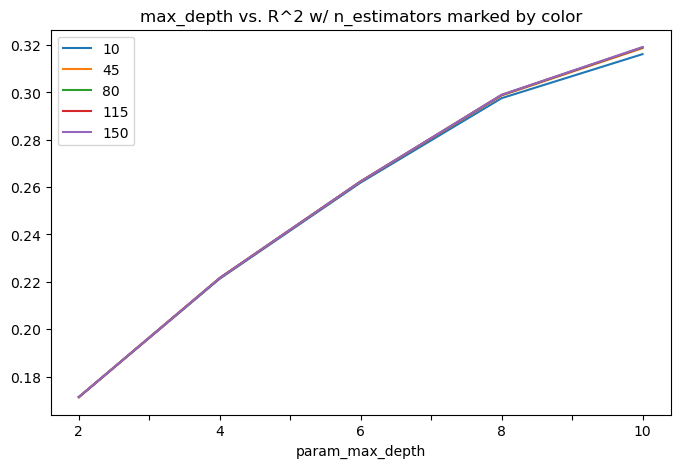

In [15]:
results_r2 = pd.DataFrame(rf_r2.cv_results_)
n_est_grouped = results_r2.groupby("param_n_estimators")

plt.figure(figsize=(8, 5))
ax1 = plt.subplot(111)
n_est_grouped.plot(y="mean_test_score", x="param_max_depth", kind='line', ax=ax1)
plt.legend(n_est_grouped.groups.keys())
plt.title('max_depth vs. R^2 w/ n_estimators marked by color')
plt.show()

### MSE

In [6]:
random_grid = {'max_depth': [2, 6, 10, 14, 18],
               'n_estimators': [10, 45, 80, 115, 150]}
rf_mse = GridSearchCV(RandomForestRegressor(random_state=42),
                      param_grid=random_grid,
                      return_train_score=True,
                      scoring='neg_mean_squared_error')
rf_mse.fit(X_dev, y_dev)
print(f"Best MSE Score:", rf_mse.best_score_)
print(f"Best Hyperparameters:", rf_mse.best_params_)
print(f"Test MSE Score:", rf_mse.score(X_test, y_test))

Best MSE Score: -1.2029333504272026
Best Hyperparameters: {'max_depth': 14, 'n_estimators': 150}
Test MSE Score: -1.1931967403790453


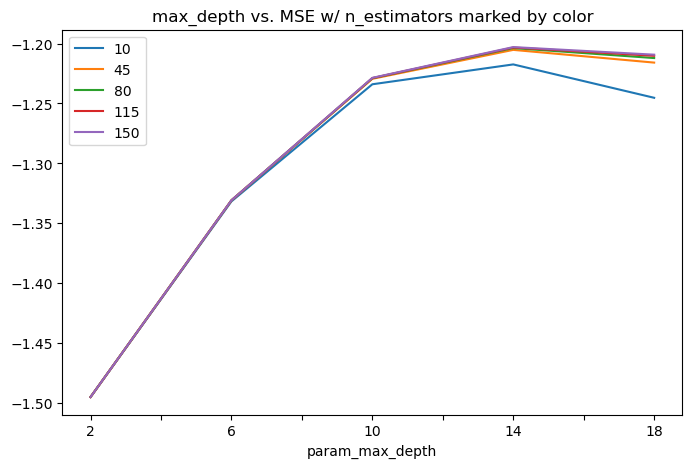

In [14]:
results_mse = pd.DataFrame(rf_mse.cv_results_)
n_est_grouped = results_mse.groupby("param_n_estimators")

plt.figure(figsize=(8, 5))
ax1 = plt.subplot(111)
n_est_grouped.plot(y="mean_test_score", x="param_max_depth", kind='line', ax=ax1)
plt.legend(n_est_grouped.groups.keys())
plt.title('max_depth vs. MSE w/ n_estimators marked by color')
plt.show()

## Feature Importance

### Tuned with R^2

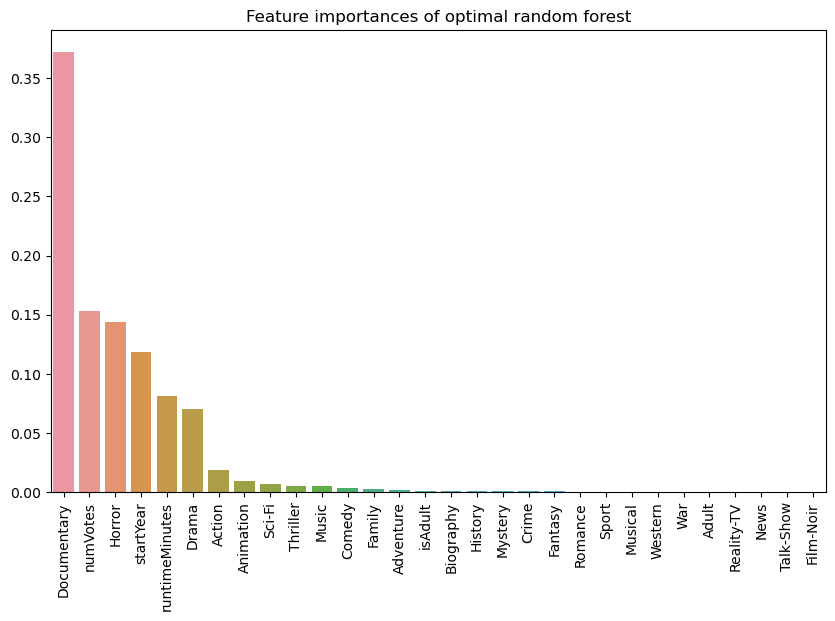

In [9]:
feat_imps = zip(X_dev.columns, rf_r2.best_estimator_.feature_importances_)
feats, imps = zip(*(sorted(list(filter(lambda x: x[1] != 0, feat_imps)),
                           key=lambda x: x[1], reverse=True)))
plt.figure(figsize=(10, 6))
sns.barplot(x=list(feats), y=list(imps))
plt.tick_params (axis='x', rotation=90)
plt.title("Feature importances of optimal random forest")
plt.show()

### Tuned with MSE

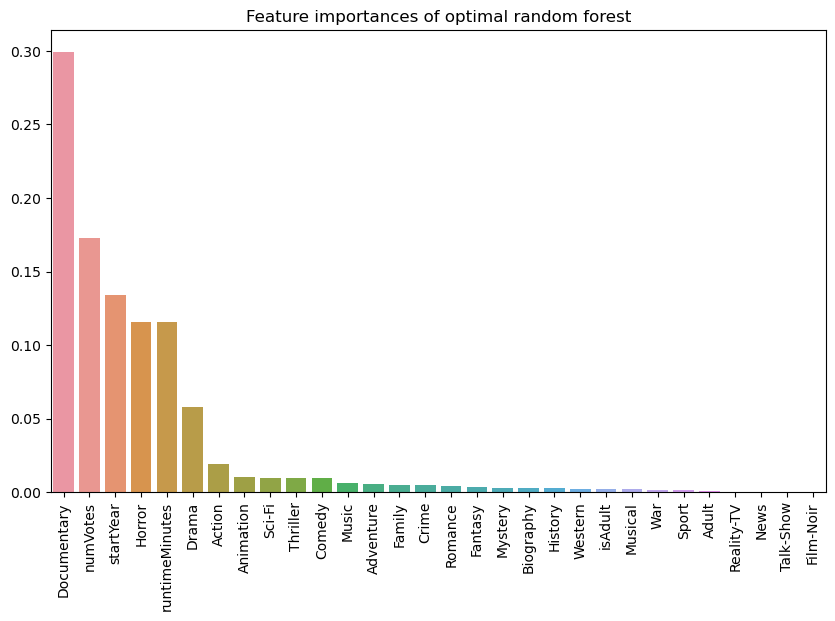

In [10]:
feat_imps = zip(X_dev.columns, rf_mse.best_estimator_.feature_importances_)
feats, imps = zip(*(sorted(list(filter(lambda x: x[1] != 0, feat_imps)),
                           key=lambda x: x[1], reverse=True)))
plt.figure(figsize=(10, 6))
sns.barplot(x=list(feats), y=list(imps))
plt.tick_params (axis='x', rotation=90)
plt.title("Feature importances of optimal random forest")
plt.show()

## Performance on test data

In [22]:
r2_pred = rf_r2.best_estimator_.predict(X_test)
print(f"Optimal Random Forest MSE = ", mean_squared_error(y_test,r2_pred))
print(f"Optimal Random Forest R^2 = ", r2_score(y_test,r2_pred))

Optimal Random Forest MSE =  1.2218796521956043
Optimal Random Forest R^2 =  0.316998798406961


In [23]:
mse_pred = rf_mse.best_estimator_.predict(X_test)
print(f"Optimal Random Forest MSE = ", mean_squared_error(y_test,mse_pred))
print(f"Optimal Random Forest R^2 = ", r2_score(y_test,mse_pred))

Optimal Random Forest MSE =  1.1931967403790453
Optimal Random Forest R^2 =  0.3330318530541144
